In [2]:
import tensorflow
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import time
import os
import pydot
import graphviz
import math
# from keras.utils.vis_utils import plot_model

In [3]:
# def plot_kps(keypoints,color):
#     connections = (
#         [0,1],
#         [1,2],
#         [3,4],
#         [4,5],
#         [2,6],
#         [3,6],
#         [6,7],
#         [7,8],
#         [8,9],
#         [10,11],
#         [11,12],
#         [12,7],
#         [13,7],
#         [13,14],
#         [14,15]
#     )
#     i = 0
#     while(i < len(connections)):
#         if (keypoints[ (connections[i][0]*2) ] >= 0) and (keypoints[ (connections[i][1]*2) ] >= 0):
#             plt.plot( ( keypoints[ (connections[i][0]*2) ]*256 , keypoints[ (connections[i][1]*2) ]*256 ) , 
#                      ( keypoints[ (connections[i][0]*2)+1 ]*256 , keypoints[ (connections[i][1]*2)+1 ]*256 ),
#                      marker='o', color=color )
#         i+=1

def plot_kps(keypoints):
    i = 0
    while(i < len(keypoints)):
        if keypoints[i] >= 0:
            plt.plot(keypoints[i],keypoints[i+1],marker='o',color='red')
        i+=2

def data_preprocessing(data,size,chunk):
    data = np.array(data.iloc[chunk[0]:chunk[1]])
    X = []
    Y = []
    count = 0
    for row in data:
        img = cv2.imread('./singleImages/' + row[0])/255.0
        X.append(img)
        y = row[1:]
        y = np.array(y).astype('float32').reshape(16,2)
#         Y.append(y)
        heatmaps = []
        for j in range(0, len(y)):
            heatmap = np.zeros((64,64)).astype('float32')  
            heatmap[int(math.ceil(y[j][1])/4),int(math.ceil(y[j][0])/4)] = 1
            heatmap = cv2.GaussianBlur(heatmap,(21,21),2,cv2.BORDER_DEFAULT)
            heatmaps.append(heatmap)
        heatmaps = np.array(heatmaps).astype('float32').swapaxes(1,2).swapaxes(0,2)
        Y.append(heatmaps)
#         if count%100==0:
#             print(count)
        count+=1
    X = np.array(X).reshape(len(X),size,size,3).astype('float32')
    Y = np.array(Y).astype('float32')
    return train_test_split(X,Y, test_size=0.2, random_state=123)

In [4]:
data = pd.read_csv('./adjusted.csv')

In [5]:
x_train, x_test, y_train, y_test = data_preprocessing(data,256,[100,110])

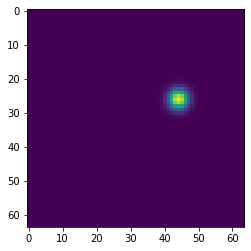

In [6]:
plt.imshow(y_train[0,:,:,2])

In [125]:
def ResidualBlock(x):
#     as specified in paper
#     batch normalization -> relu first instead of conv due to remapping of orgiinal input image size to 64x64
#     ^ at time of first call to ResidualBlock the previous conv layer had no bn or activation function
#     it functions the same as a differnt ordering with bn and an activation before being fed into first res block
#     simply for consistency with paper
    residual = x
    
    out = BatchNormalization(momentum=0.1,epsilon=1e-5)(x)
    out = ReLU()(out)
    out = Conv2D(32*2, kernel_size=(1,1),strides=1)(out)
    
    out = BatchNormalization(momentum=0.1,epsilon=1e-5)(out)
    out = ReLU()(out)
    out = Conv2D(32*2, kernel_size=(3,3),strides=1, padding='same')(out)
    
    out = BatchNormalization(momentum=0.1,epsilon=1e-5)(out)
    out = ReLU()(out)
    out = Conv2D(64*2, kernel_size=(1,1),strides=1)(out)
    
    out += residual
    return out

def linear(x):
#     bn -> conv -> relu as specified in paper
#     output that we can apply loss too, typically two in succession for final output
    out = BatchNormalization(momentum=0.1,epsilon=1e-5)(x)
    out = Conv2D(16,kernel_size=(1,1))(out)
    out = ReLU()(out)
    return out

def hourglass(x):
#   res1, res2... resn and so on are from different layers at different resolutions
#   feature maps are combined after taking two outputs from different resolutions through residual connections
#   upsampling the smallest one, then combining them pixel wise
#   residual from outside hourglass before and after hourglass input and output are handled outside of this method below
    res1 = x
    
    outputs = ResidualBlock(x)
    outputs = MaxPooling2D(pool_size=(2,2))(outputs)

    res2 = outputs

    outputs = ResidualBlock(outputs)
    outputs = MaxPooling2D(pool_size=(2,2))(outputs)

    res3 = outputs

    outputs = ResidualBlock(outputs)
    outputs = MaxPooling2D(pool_size=(2,2))(outputs)

    res4 = outputs

    outputs = ResidualBlock(outputs)
    outputs = MaxPooling2D(pool_size=(2,2))(outputs)

    outputs = ResidualBlock(outputs)
    outputs = ResidualBlock(outputs)
    outputs = ResidualBlock(outputs)
    outputs = UpSampling2D(size=(2, 2), interpolation="nearest")(outputs)

    outputs += res4

    outputs = ResidualBlock(outputs)
    outputs = UpSampling2D(size=(2, 2), interpolation="nearest")(outputs)

    outputs += res3

    outputs = ResidualBlock(outputs)
    outputs = UpSampling2D(size=(2, 2), interpolation="nearest")(outputs)

    outputs += res2

    outputs = ResidualBlock(outputs)
    outputs = UpSampling2D(size=(2, 2), interpolation="nearest")(outputs)

    outputs += res1

    outputs = ResidualBlock(outputs)
    
    return outputs

def intermediateSupervision(x,res):
#     output from previous hourglass and residual from input into said hourglass, x and res respectively  
#     output from previous is fed into a res block, then mapped to an output that we can apply loss to
#     once we have that, we save it and return it for adding it as an output later so it will actually apply loss
#     the output is then remapped to 128 filters for layer addition purposes in the res blocks and then is combined 
#     with the output from before the hourglass and the output thats been fed through two res blocks
    out = ResidualBlock(x)
    intermediate = linear(out)
    res2 = Conv2D(64*2,kernel_size=(1,1),strides=1)(intermediate)
    out = ResidualBlock(out)
    out += res
    out += res2
    return out, intermediate

# specified exactly in research paper
# downsizes to 64 x 64 x 128
# paper used values 128 and 256 output filers, we used 64 and 128 for runtime and space reasons

inputs = Input(shape=(256,256,3))
outputs = Conv2D(64*2,kernel_size=(7,7),strides=2,padding='same')(inputs)
outputs = ResidualBlock(outputs)
outputs = MaxPooling2D(pool_size=(2,2))(outputs)

# layers of the model, intermediateSupervisedOutput(x) is an output from one of the hourglass being fed into the next
# we add these as outputs so loss can be applied
# when predicting because of the 8 outputs, simply grab the first output of the list of 64x64x16 heatmaps it outputs

res1 = outputs
outputs = hourglass(outputs)
outputs, intermediateSupervisedOutput1 = intermediateSupervision(outputs,res1)


res2 = outputs
outputs = hourglass(outputs)
outputs, intermediateSupervisedOutput2 = intermediateSupervision(outputs,res2)


res3 = outputs
outputs = hourglass(outputs)
outputs, intermediateSupervisedOutput3 = intermediateSupervision(outputs,res3)

res4 = outputs
outputs = hourglass(outputs)
outputs, intermediateSupervisedOutput4 = intermediateSupervision(outputs,res4)

res5 = outputs
outputs = hourglass(outputs)
outputs, intermediateSupervisedOutput5 = intermediateSupervision(outputs,res5)

res6 = outputs
outputs = hourglass(outputs)
outputs, intermediateSupervisedOutput6 = intermediateSupervision(outputs,res6)

res7 = outputs
outputs = hourglass(outputs)
outputs, intermediateSupervisedOutput7 = intermediateSupervision(outputs,res7)


outputs = hourglass(outputs)#last hourglass needs no residual or intermediate supervision loss

# two 1x1 convolutions of output_filter amount = n_keypoints as specified in research
outputs = linear(outputs)
outputs = linear(outputs)


# applies loss at the output of each hourglass then remaps it back to 128 output features and feeds into next hourglass
model = Model(inputs,[outputs,
                     intermediateSupervisedOutput1,
                     intermediateSupervisedOutput2,
                     intermediateSupervisedOutput3,
                     intermediateSupervisedOutput4,
                     intermediateSupervisedOutput5,
                     intermediateSupervisedOutput6,
                     intermediateSupervisedOutput7])

# model = Model(inputs,outputs)
model.summary()
model.compile( optimizer='adam', loss=['mse'], metrics=['accuracy'])

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2633 (Conv2D)            (None, 128, 128, 128 18944       input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2568 (Batch (None, 128, 128, 128 512         conv2d_2633[0][0]                
__________________________________________________________________________________________________
re_lu_2568 (ReLU)               (None, 128, 128, 128 0           batch_normalization_2568[0][0]   
___________________________________________________________________________________________

batch_normalization_2795 (Batch (None, 16, 16, 128)  512         tf.__operators__.add_1312[0][0]  
__________________________________________________________________________________________________
re_lu_2795 (ReLU)               (None, 16, 16, 128)  0           batch_normalization_2795[0][0]   
__________________________________________________________________________________________________
conv2d_2866 (Conv2D)            (None, 16, 16, 64)   8256        re_lu_2795[0][0]                 
__________________________________________________________________________________________________
batch_normalization_2796 (Batch (None, 16, 16, 64)   256         conv2d_2866[0][0]                
__________________________________________________________________________________________________
re_lu_2796 (ReLU)               (None, 16, 16, 64)   0           batch_normalization_2796[0][0]   
__________________________________________________________________________________________________
conv2d_286

In [135]:
import time

In [140]:
time1 = time.time()
img = np.array(x_train[0]).reshape(1,256,256,3)
model.predict(img)
time2 = time.time()
time2-time1
# speed is slower when testing on lower battery mode on pc, averaged around 250 miliseconds when plugged in

0.605186939239502

In [141]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial",128)
visualkeras.layered_view(model, to_file='hourglass.png',font=font,legend=True)

In [105]:
def train(start,end,increment):
    i = start
    while(i <= end):
        x_train, x_test, y_train, y_test = data_preprocessing(data,256,[i,i+increment])
        model.fit( x_train, y_train, epochs=10, batch_size=32, validation_split=0.1 )
        model.save('8_stack_with_intermediate_supervision_checkpoint' + str(i) + "-" + str(i+increment))
        i+=increment

In [106]:
# x_train, x_test, y_train, y_test = data_preprocessing(data,256,[0,2000])
# model.fit( x_train, y_train, epochs=5, batch_size=64, validation_split=0.1 )
train(0,10000,500)

Epoch 1/10
12/12 [==============================] - 533s 42s/step - loss: 2.8234 - re_lu_2102_loss: 0.2835 - re_lu_1824_loss: 0.3950 - re_lu_1864_loss: 0.2945 - re_lu_1904_loss: 0.4269 - re_lu_1944_loss: 0.3721 - re_lu_1984_loss: 0.3880 - re_lu_2024_loss: 0.3555 - re_lu_2064_loss: 0.3077 - re_lu_2102_accuracy: 0.0551 - re_lu_1824_accuracy: 0.0588 - re_lu_1864_accuracy: 0.0690 - re_lu_1904_accuracy: 0.0670 - re_lu_1944_accuracy: 0.0569 - re_lu_1984_accuracy: 0.0602 - re_lu_2024_accuracy: 0.0670 - re_lu_2064_accuracy: 0.0664 - val_loss: 0.8697 - val_re_lu_2102_loss: 0.2004 - val_re_lu_1824_loss: 0.0900 - val_re_lu_1864_loss: 0.0796 - val_re_lu_1904_loss: 0.1143 - val_re_lu_1944_loss: 0.0925 - val_re_lu_1984_loss: 0.1082 - val_re_lu_2024_loss: 0.0907 - val_re_lu_2064_loss: 0.0939 - val_re_lu_2102_accuracy: 0.0496 - val_re_lu_1824_accuracy: 0.0571 - val_re_lu_1864_accuracy: 0.0707 - val_re_lu_1904_accuracy: 0.0690 - val_re_lu_1944_accuracy: 0.0679 - val_re_lu_1984_accuracy: 0.0549 - val_re

Epoch 9/10
12/12 [==============================] - 454s 37s/step - loss: 0.0050 - re_lu_2102_loss: 0.0023 - re_lu_1824_loss: 5.8511e-04 - re_lu_1864_loss: 2.6756e-04 - re_lu_1904_loss: 3.3543e-04 - re_lu_1944_loss: 4.2443e-04 - re_lu_1984_loss: 3.2291e-04 - re_lu_2024_loss: 3.2832e-04 - re_lu_2064_loss: 4.3498e-04 - re_lu_2102_accuracy: 0.0551 - re_lu_1824_accuracy: 0.1036 - re_lu_1864_accuracy: 0.1160 - re_lu_1904_accuracy: 0.1115 - re_lu_1944_accuracy: 0.0986 - re_lu_1984_accuracy: 0.1227 - re_lu_2024_accuracy: 0.1081 - re_lu_2064_accuracy: 0.1086 - val_loss: 0.0125 - val_re_lu_2102_loss: 0.0086 - val_re_lu_1824_loss: 8.9860e-04 - val_re_lu_1864_loss: 5.3634e-04 - val_re_lu_1904_loss: 5.3682e-04 - val_re_lu_1944_loss: 5.2011e-04 - val_re_lu_1984_loss: 4.7348e-04 - val_re_lu_2024_loss: 4.1775e-04 - val_re_lu_2064_loss: 6.0000e-04 - val_re_lu_2102_accuracy: 0.0525 - val_re_lu_1824_accuracy: 0.1002 - val_re_lu_1864_accuracy: 0.1224 - val_re_lu_1904_accuracy: 0.1249 - val_re_lu_1944_acc

12/12 [==============================] - 524s 43s/step - loss: 0.0011 - re_lu_2102_loss: 3.8110e-04 - re_lu_1824_loss: 1.5643e-04 - re_lu_1864_loss: 7.3946e-05 - re_lu_1904_loss: 9.2171e-05 - re_lu_1944_loss: 1.0651e-04 - re_lu_1984_loss: 8.4150e-05 - re_lu_2024_loss: 9.4599e-05 - re_lu_2064_loss: 1.1050e-04 - re_lu_2102_accuracy: 0.0720 - re_lu_1824_accuracy: 0.1670 - re_lu_1864_accuracy: 0.1894 - re_lu_1904_accuracy: 0.1901 - re_lu_1944_accuracy: 0.1720 - re_lu_1984_accuracy: 0.1944 - re_lu_2024_accuracy: 0.1866 - re_lu_2064_accuracy: 0.1790 - val_loss: 0.0019 - val_re_lu_2102_loss: 5.6912e-04 - val_re_lu_1824_loss: 2.4995e-04 - val_re_lu_1864_loss: 1.1117e-04 - val_re_lu_1904_loss: 1.9859e-04 - val_re_lu_1944_loss: 1.4000e-04 - val_re_lu_1984_loss: 1.6318e-04 - val_re_lu_2024_loss: 1.6374e-04 - val_re_lu_2064_loss: 2.7231e-04 - val_re_lu_2102_accuracy: 0.0723 - val_re_lu_1824_accuracy: 0.1382 - val_re_lu_1864_accuracy: 0.1748 - val_re_lu_1904_accuracy: 0.1583 - val_re_lu_1944_accura

12/12 [==============================] - 1147s 95s/step - loss: 5.9328e-04 - re_lu_2102_loss: 1.6013e-04 - re_lu_1824_loss: 9.6919e-05 - re_lu_1864_loss: 4.7879e-05 - re_lu_1904_loss: 5.7303e-05 - re_lu_1944_loss: 7.0550e-05 - re_lu_1984_loss: 4.5902e-05 - re_lu_2024_loss: 5.1986e-05 - re_lu_2064_loss: 6.2614e-05 - re_lu_2102_accuracy: 0.1007 - re_lu_1824_accuracy: 0.1985 - re_lu_1864_accuracy: 0.2256 - re_lu_1904_accuracy: 0.2171 - re_lu_1944_accuracy: 0.2021 - re_lu_1984_accuracy: 0.2263 - re_lu_2024_accuracy: 0.2243 - re_lu_2064_accuracy: 0.2134 - val_loss: 0.0047 - val_re_lu_2102_loss: 0.0043 - val_re_lu_1824_loss: 1.9278e-04 - val_re_lu_1864_loss: 7.6456e-05 - val_re_lu_1904_loss: 4.6446e-05 - val_re_lu_1944_loss: 5.4594e-05 - val_re_lu_1984_loss: 3.0253e-05 - val_re_lu_2024_loss: 4.8217e-05 - val_re_lu_2064_loss: 3.4181e-05 - val_re_lu_2102_accuracy: 0.0790 - val_re_lu_1824_accuracy: 0.1680 - val_re_lu_1864_accuracy: 0.2113 - val_re_lu_1904_accuracy: 0.2075 - val_re_lu_1944_accur

12/12 [==============================] - 1144s 95s/step - loss: 2.6051e-04 - re_lu_2102_loss: 6.3275e-05 - re_lu_1824_loss: 4.4365e-05 - re_lu_1864_loss: 2.2718e-05 - re_lu_1904_loss: 2.5972e-05 - re_lu_1944_loss: 3.1404e-05 - re_lu_1984_loss: 2.0375e-05 - re_lu_2024_loss: 2.4092e-05 - re_lu_2064_loss: 2.8309e-05 - re_lu_2102_accuracy: 0.1545 - re_lu_1824_accuracy: 0.2390 - re_lu_1864_accuracy: 0.2585 - re_lu_1904_accuracy: 0.2564 - re_lu_1944_accuracy: 0.2452 - re_lu_1984_accuracy: 0.2611 - re_lu_2024_accuracy: 0.2605 - re_lu_2064_accuracy: 0.2551 - val_loss: 0.0054 - val_re_lu_2102_loss: 0.0047 - val_re_lu_1824_loss: 1.8302e-04 - val_re_lu_1864_loss: 1.0800e-04 - val_re_lu_1904_loss: 1.2568e-04 - val_re_lu_1944_loss: 4.6814e-05 - val_re_lu_1984_loss: 6.8380e-05 - val_re_lu_2024_loss: 6.2376e-05 - val_re_lu_2064_loss: 3.5296e-05 - val_re_lu_2102_accuracy: 0.0897 - val_re_lu_1824_accuracy: 0.1887 - val_re_lu_1864_accuracy: 0.1982 - val_re_lu_1904_accuracy: 0.2057 - val_re_lu_1944_accur

12/12 [==============================] - 1176s 97s/step - loss: 1.5515e-04 - re_lu_2102_loss: 4.2502e-05 - re_lu_1824_loss: 2.1224e-05 - re_lu_1864_loss: 1.3360e-05 - re_lu_1904_loss: 1.6090e-05 - re_lu_1944_loss: 1.6945e-05 - re_lu_1984_loss: 1.3908e-05 - re_lu_2024_loss: 1.4620e-05 - re_lu_2064_loss: 1.6501e-05 - re_lu_2102_accuracy: 0.1767 - re_lu_1824_accuracy: 0.2519 - re_lu_1864_accuracy: 0.2615 - re_lu_1904_accuracy: 0.2576 - re_lu_1944_accuracy: 0.2571 - re_lu_1984_accuracy: 0.2661 - re_lu_2024_accuracy: 0.2636 - re_lu_2064_accuracy: 0.2631 - val_loss: 2.3917e-04 - val_re_lu_2102_loss: 5.9318e-05 - val_re_lu_1824_loss: 3.4863e-05 - val_re_lu_1864_loss: 1.9259e-05 - val_re_lu_1904_loss: 2.7694e-05 - val_re_lu_1944_loss: 2.2860e-05 - val_re_lu_1984_loss: 1.6803e-05 - val_re_lu_2024_loss: 3.4982e-05 - val_re_lu_2064_loss: 2.3385e-05 - val_re_lu_2102_accuracy: 0.1960 - val_re_lu_1824_accuracy: 0.2379 - val_re_lu_1864_accuracy: 0.2548 - val_re_lu_1904_accuracy: 0.2394 - val_re_lu_19

12/12 [==============================] - 1195s 99s/step - loss: 1.1270e-04 - re_lu_2102_loss: 2.5845e-05 - re_lu_1824_loss: 1.6512e-05 - re_lu_1864_loss: 1.0716e-05 - re_lu_1904_loss: 1.2233e-05 - re_lu_1944_loss: 1.2694e-05 - re_lu_1984_loss: 1.1059e-05 - re_lu_2024_loss: 1.1574e-05 - re_lu_2064_loss: 1.2068e-05 - re_lu_2102_accuracy: 0.2035 - re_lu_1824_accuracy: 0.2579 - re_lu_1864_accuracy: 0.2669 - re_lu_1904_accuracy: 0.2657 - re_lu_1944_accuracy: 0.2616 - re_lu_1984_accuracy: 0.2714 - re_lu_2024_accuracy: 0.2662 - re_lu_2064_accuracy: 0.2651 - val_loss: 4.9632e-04 - val_re_lu_2102_loss: 2.2252e-04 - val_re_lu_1824_loss: 6.2410e-05 - val_re_lu_1864_loss: 3.3356e-05 - val_re_lu_1904_loss: 5.2923e-05 - val_re_lu_1944_loss: 2.7313e-05 - val_re_lu_1984_loss: 2.8906e-05 - val_re_lu_2024_loss: 4.3157e-05 - val_re_lu_2064_loss: 2.5745e-05 - val_re_lu_2102_accuracy: 0.1873 - val_re_lu_1824_accuracy: 0.2234 - val_re_lu_1864_accuracy: 0.2375 - val_re_lu_1904_accuracy: 0.2394 - val_re_lu_19

12/12 [==============================] - 1261s 104s/step - loss: 1.1463e-04 - re_lu_2102_loss: 1.9671e-05 - re_lu_1824_loss: 1.8276e-05 - re_lu_1864_loss: 1.1677e-05 - re_lu_1904_loss: 1.3231e-05 - re_lu_1944_loss: 1.4314e-05 - re_lu_1984_loss: 1.1684e-05 - re_lu_2024_loss: 1.2031e-05 - re_lu_2064_loss: 1.3751e-05 - re_lu_2102_accuracy: 0.2275 - re_lu_1824_accuracy: 0.2657 - re_lu_1864_accuracy: 0.2768 - re_lu_1904_accuracy: 0.2784 - re_lu_1944_accuracy: 0.2710 - re_lu_1984_accuracy: 0.2764 - re_lu_2024_accuracy: 0.2795 - re_lu_2064_accuracy: 0.2802 - val_loss: 2.5738e-04 - val_re_lu_2102_loss: 8.4992e-05 - val_re_lu_1824_loss: 4.0716e-05 - val_re_lu_1864_loss: 1.8649e-05 - val_re_lu_1904_loss: 1.7228e-05 - val_re_lu_1944_loss: 2.1438e-05 - val_re_lu_1984_loss: 1.7761e-05 - val_re_lu_2024_loss: 3.8799e-05 - val_re_lu_2064_loss: 1.7800e-05 - val_re_lu_2102_accuracy: 0.1788 - val_re_lu_1824_accuracy: 0.2435 - val_re_lu_1864_accuracy: 0.2597 - val_re_lu_1904_accuracy: 0.2598 - val_re_lu_1

12/12 [==============================] - 1191s 99s/step - loss: 7.9651e-05 - re_lu_2102_loss: 1.4943e-05 - re_lu_1824_loss: 1.2333e-05 - re_lu_1864_loss: 8.6968e-06 - re_lu_1904_loss: 8.8575e-06 - re_lu_1944_loss: 9.4849e-06 - re_lu_1984_loss: 7.9194e-06 - re_lu_2024_loss: 8.5080e-06 - re_lu_2064_loss: 8.9083e-06 - re_lu_2102_accuracy: 0.2472 - re_lu_1824_accuracy: 0.2808 - re_lu_1864_accuracy: 0.2887 - re_lu_1904_accuracy: 0.2899 - re_lu_1944_accuracy: 0.2836 - re_lu_1984_accuracy: 0.2917 - re_lu_2024_accuracy: 0.2908 - re_lu_2064_accuracy: 0.2890 - val_loss: 8.3519e-05 - val_re_lu_2102_loss: 1.8424e-05 - val_re_lu_1824_loss: 1.2930e-05 - val_re_lu_1864_loss: 8.1414e-06 - val_re_lu_1904_loss: 9.2572e-06 - val_re_lu_1944_loss: 1.0857e-05 - val_re_lu_1984_loss: 7.4180e-06 - val_re_lu_2024_loss: 8.2070e-06 - val_re_lu_2064_loss: 8.2837e-06 - val_re_lu_2102_accuracy: 0.2221 - val_re_lu_1824_accuracy: 0.2695 - val_re_lu_1864_accuracy: 0.2784 - val_re_lu_1904_accuracy: 0.2739 - val_re_lu_19

12/12 [==============================] - 1060s 88s/step - loss: 7.6850e-05 - re_lu_2102_loss: 1.4805e-05 - re_lu_1824_loss: 1.2023e-05 - re_lu_1864_loss: 8.1612e-06 - re_lu_1904_loss: 8.5135e-06 - re_lu_1944_loss: 8.7895e-06 - re_lu_1984_loss: 7.7977e-06 - re_lu_2024_loss: 8.1255e-06 - re_lu_2064_loss: 8.6347e-06 - re_lu_2102_accuracy: 0.2463 - re_lu_1824_accuracy: 0.2819 - re_lu_1864_accuracy: 0.2881 - re_lu_1904_accuracy: 0.2875 - re_lu_1944_accuracy: 0.2849 - re_lu_1984_accuracy: 0.2908 - re_lu_2024_accuracy: 0.2896 - re_lu_2064_accuracy: 0.2885 - val_loss: 9.4551e-05 - val_re_lu_2102_loss: 2.1982e-05 - val_re_lu_1824_loss: 1.1376e-05 - val_re_lu_1864_loss: 8.7349e-06 - val_re_lu_1904_loss: 8.1815e-06 - val_re_lu_1944_loss: 1.1743e-05 - val_re_lu_1984_loss: 8.1433e-06 - val_re_lu_2024_loss: 1.5252e-05 - val_re_lu_2064_loss: 9.1392e-06 - val_re_lu_2102_accuracy: 0.2486 - val_re_lu_1824_accuracy: 0.3034 - val_re_lu_1864_accuracy: 0.3034 - val_re_lu_1904_accuracy: 0.3025 - val_re_lu_19

12/12 [==============================] - 2073s 172s/step - loss: 6.2163e-05 - re_lu_2102_loss: 1.1735e-05 - re_lu_1824_loss: 9.1393e-06 - re_lu_1864_loss: 6.8547e-06 - re_lu_1904_loss: 6.6949e-06 - re_lu_1944_loss: 7.6038e-06 - re_lu_1984_loss: 6.4583e-06 - re_lu_2024_loss: 6.9147e-06 - re_lu_2064_loss: 6.7625e-06 - re_lu_2102_accuracy: 0.2532 - re_lu_1824_accuracy: 0.2861 - re_lu_1864_accuracy: 0.2893 - re_lu_1904_accuracy: 0.2878 - re_lu_1944_accuracy: 0.2869 - re_lu_1984_accuracy: 0.2907 - re_lu_2024_accuracy: 0.2878 - re_lu_2064_accuracy: 0.2897 - val_loss: 6.8891e-05 - val_re_lu_2102_loss: 1.9279e-05 - val_re_lu_1824_loss: 9.8896e-06 - val_re_lu_1864_loss: 6.5626e-06 - val_re_lu_1904_loss: 6.1872e-06 - val_re_lu_1944_loss: 7.3938e-06 - val_re_lu_1984_loss: 6.6551e-06 - val_re_lu_2024_loss: 7.2024e-06 - val_re_lu_2064_loss: 5.7214e-06 - val_re_lu_2102_accuracy: 0.1821 - val_re_lu_1824_accuracy: 0.2701 - val_re_lu_1864_accuracy: 0.2787 - val_re_lu_1904_accuracy: 0.2855 - val_re_lu_1

12/12 [==============================] - 2065s 171s/step - loss: 5.3648e-05 - re_lu_2102_loss: 8.5153e-06 - re_lu_1824_loss: 7.7762e-06 - re_lu_1864_loss: 6.2801e-06 - re_lu_1904_loss: 6.0855e-06 - re_lu_1944_loss: 6.8935e-06 - re_lu_1984_loss: 5.8267e-06 - re_lu_2024_loss: 6.0075e-06 - re_lu_2064_loss: 6.2629e-06 - re_lu_2102_accuracy: 0.2710 - re_lu_1824_accuracy: 0.2885 - re_lu_1864_accuracy: 0.2910 - re_lu_1904_accuracy: 0.2904 - re_lu_1944_accuracy: 0.2895 - re_lu_1984_accuracy: 0.2933 - re_lu_2024_accuracy: 0.2906 - re_lu_2064_accuracy: 0.2910 - val_loss: 1.5260e-04 - val_re_lu_2102_loss: 8.5397e-05 - val_re_lu_1824_loss: 1.0913e-05 - val_re_lu_1864_loss: 1.0201e-05 - val_re_lu_1904_loss: 8.2375e-06 - val_re_lu_1944_loss: 8.3987e-06 - val_re_lu_1984_loss: 7.8174e-06 - val_re_lu_2024_loss: 8.9807e-06 - val_re_lu_2064_loss: 1.2659e-05 - val_re_lu_2102_accuracy: 0.2391 - val_re_lu_1824_accuracy: 0.2784 - val_re_lu_1864_accuracy: 0.2812 - val_re_lu_1904_accuracy: 0.2789 - val_re_lu_1

12/12 [==============================] - 1866s 155s/step - loss: 5.5095e-05 - re_lu_2102_loss: 1.2327e-05 - re_lu_1824_loss: 7.1205e-06 - re_lu_1864_loss: 5.6731e-06 - re_lu_1904_loss: 6.0381e-06 - re_lu_1944_loss: 5.9527e-06 - re_lu_1984_loss: 5.9486e-06 - re_lu_2024_loss: 6.1236e-06 - re_lu_2064_loss: 5.9110e-06 - re_lu_2102_accuracy: 0.2589 - re_lu_1824_accuracy: 0.2849 - re_lu_1864_accuracy: 0.2889 - re_lu_1904_accuracy: 0.2865 - re_lu_1944_accuracy: 0.2873 - re_lu_1984_accuracy: 0.2908 - re_lu_2024_accuracy: 0.2887 - re_lu_2064_accuracy: 0.2882 - val_loss: 1.7695e-04 - val_re_lu_2102_loss: 1.3141e-04 - val_re_lu_1824_loss: 7.1111e-06 - val_re_lu_1864_loss: 6.3703e-06 - val_re_lu_1904_loss: 6.0981e-06 - val_re_lu_1944_loss: 7.8315e-06 - val_re_lu_1984_loss: 5.5098e-06 - val_re_lu_2024_loss: 6.5422e-06 - val_re_lu_2064_loss: 6.0859e-06 - val_re_lu_2102_accuracy: 0.1837 - val_re_lu_1824_accuracy: 0.2733 - val_re_lu_1864_accuracy: 0.2782 - val_re_lu_1904_accuracy: 0.2758 - val_re_lu_1

12/12 [==============================] - 2294s 191s/step - loss: 5.1766e-05 - re_lu_2102_loss: 7.7615e-06 - re_lu_1824_loss: 6.9457e-06 - re_lu_1864_loss: 5.8350e-06 - re_lu_1904_loss: 5.9908e-06 - re_lu_1944_loss: 6.2464e-06 - re_lu_1984_loss: 5.7636e-06 - re_lu_2024_loss: 6.6799e-06 - re_lu_2064_loss: 6.5433e-06 - re_lu_2102_accuracy: 0.2764 - re_lu_1824_accuracy: 0.2917 - re_lu_1864_accuracy: 0.2940 - re_lu_1904_accuracy: 0.2956 - re_lu_1944_accuracy: 0.2916 - re_lu_1984_accuracy: 0.2952 - re_lu_2024_accuracy: 0.2945 - re_lu_2064_accuracy: 0.2935 - val_loss: 7.8647e-05 - val_re_lu_2102_loss: 1.6101e-05 - val_re_lu_1824_loss: 9.5812e-06 - val_re_lu_1864_loss: 6.7330e-06 - val_re_lu_1904_loss: 6.6861e-06 - val_re_lu_1944_loss: 1.4801e-05 - val_re_lu_1984_loss: 9.1991e-06 - val_re_lu_2024_loss: 6.9668e-06 - val_re_lu_2064_loss: 8.5795e-06 - val_re_lu_2102_accuracy: 0.2312 - val_re_lu_1824_accuracy: 0.2764 - val_re_lu_1864_accuracy: 0.2834 - val_re_lu_1904_accuracy: 0.2861 - val_re_lu_1

KeyboardInterrupt: 

(8, 64, 64, 16)


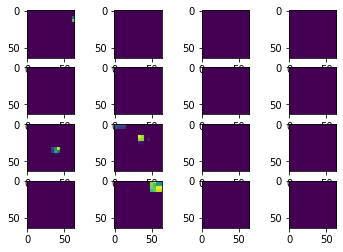

In [115]:
x_train[0].shape
img = np.array(x_train[0]).reshape(1,256,256,3)
pred = np.array(model.predict(img)).squeeze()
print(pred.shape)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(pred[0,:,:,i])

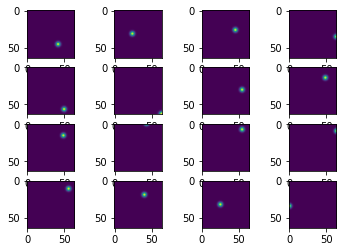

In [118]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(y_train[0,:,:,i])

In [62]:
j = 0

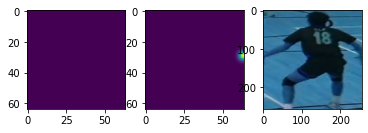

In [73]:
img = np.array(x_train[1]).reshape(1,256,256,3)
pred = np.array(model.predict(img)).squeeze()
plt.subplot(1,3,1)
plt.imshow(pred[:,:,j])
plt.subplot(1,3,2)
plt.imshow(y_train[1,:,:,j])
plt.subplot(1,3,3)
plt.imshow(x_train[1])
j+=1